## Definitions

In [235]:
#import the necessary libraries to analyze the data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

samples_names = ["DKDH1", "DKDH2", "DKTH1", "DKTH2", "TKDH1", "TKDH2", "TKTH1", "TKTH2"]
dict_ = {}
for i in range(0, 8):
    dict_[i] = samples_names[i]

def compute_Isc(df):
    I_sc = []
    col_names = list(df)
    #find the index of the cell that is closest to 0 for column 1
    for i in range(0, 3):
        I_sc.append(df[col_names[2*i+1]][df[col_names[2*i]].sub(0).abs().idxmin()])
    return I_sc

def compute_Voc(df):
    V_oc = []
    col_names = list(df)
    #find the index of the cell that is closest to 0 for column 1
    for i in range(0, 3):
        V_oc.append(df[col_names[2*i]][df[col_names[2*i+1]].sub(0).abs().idxmin()])
    return V_oc

def read_eff_from_excel(path, file, sheet_nb):
    df_ = pd.read_excel(path + "\\" + file , sheet_name=sheet_nb, usecols="C:H")
    #remove the rows with nan
    df_ = df_.dropna()
    #reset the index
    df_ = df_.reset_index(drop=True)
    #drop rows 0:4
    df_ = df_.drop(df_.index[0:7])
    df_ = df_.reset_index(drop=True)

    col_names = list(df_)
    new_col_names = ["#cell", "A", "J", "V", "FF", "Eff"]

    #rename the columns 
    df_.rename(columns={col_names[0]: new_col_names[0], col_names[1]: new_col_names[1], col_names[2]: new_col_names[2], col_names[3]: new_col_names[3], 
                     col_names[4]: new_col_names[4], col_names[5]: new_col_names[5]}, inplace=True)
    return df_


def simplify_name(str):
    #remove the .xls
    str = str[:-4]
    #remove the "-"
    str = str.replace("-", "_")
    return str


def get_charac_df(path, sheet_nb):
    files = os.listdir(path)
    name_sample = []
    efficiencies = []
    Isc = []
    Voc = []
    FF = []

    if sheet_nb == "direct":
        sheet_nb = 0
    elif sheet_nb == "reverse":
        sheet_nb = 1

    #for each file in the folder, read the data from the excel usin the function read_eff_from_excel
    for file in files:
        #if the file name containts ".xls"
        if ".xls" in file:
            name_sample.append(simplify_name(file))
            df_eff = read_eff_from_excel(path, file, sheet_nb)
            efficiencies.append(df_eff["Eff"].max())
            Isc.append(df_eff["J"].max())
            Voc.append(df_eff["V"].max())
            FF.append(df_eff["FF"].max())
            #keep only 2 decimals
            efficiencies = [round(num, 2) for num in efficiencies]
            Isc = [round(num, 2) for num in Isc]
            Voc = [round(num, 2) for num in Voc]
            FF = [round(num, 2) for num in FF]
        

    #make a dataframe with the name of the sample as the first row
    df_eff = pd.DataFrame(columns=name_sample)
    df_eff.loc[len(df_eff)] = efficiencies
    df_eff.loc[len(df_eff)] = Isc
    df_eff.loc[len(df_eff)] = Voc
    df_eff.loc[len(df_eff)] = FF
    df_eff.rename(index={0: "Eff", 1: "Isc [mA/cm2]", 2: "Voc [mV]", 3:"FF %"}, inplace=True)

    #drop the columns with "TEST" in the name
    df_eff = df_eff.drop(df_eff.columns[df_eff.columns.str.contains('TEST',case = False)],axis = 1)
    return df_eff


def plot_jv(path, file):
    #read the data from the excel file from the path, and store it in a dataframe
    #use column BA until BF
    df = pd.read_excel(path + "\\" + file , sheet_name=1, usecols="BA:BF", skiprows=[0, 1, 2, 3])
    col_names = list(df)
    new_col_names = ["V_1", "I_1", "V_2", "I_2", "V_3", "I_3"]

    df.rename(columns={col_names[0]: new_col_names[0], col_names[1]: new_col_names[1], col_names[2]: new_col_names[2], col_names[3]: new_col_names[3], 
                    col_names[4]: new_col_names[4], col_names[5]: new_col_names[5]}, inplace=True)

    #read data from the same excel file, but from C7 to H9
    df_1 = pd.read_excel(path + "\\" + file , sheet_name=1, usecols="C:H")
    #remove the rows with nan
    df_1 = df_1.dropna()
    #reset the index
    df_1 = df_1.reset_index(drop=True)
    #drop rows 0:4
    df_1 = df_1.drop(df_1.index[0:6])
    df_1 = df_1.reset_index(drop=True)

    col_names = list(df_1)
    new_col_names = ["#cell", "A", "J", "V", "FF", "Eff"]

    #rename the columns 
    df_1.rename(columns={col_names[0]: new_col_names[0], col_names[1]: new_col_names[1], col_names[2]: new_col_names[2], col_names[3]: new_col_names[3], 
                        col_names[4]: new_col_names[4], col_names[5]: new_col_names[5]}, inplace=True)

    I_sc = compute_Isc(df);
    V_oc = compute_Voc(df);

    #make three plots, one for each voltage and current
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].plot(df["V_1"], df["I_1"])
    ax[1].plot(df["V_2"], df["I_2"])
    ax[2].plot(df["V_3"], df["I_3"])
    for i in range(3):
        ax[i].set_xlabel("Voltage (V)")
        ax[i].set_ylabel("Current (mA)")
        #add a light grid to the plot
        ax[i].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
        ax[i].axhline(y=0, color='r')
        ax[i].axvline(x=0, color='r')
        #write the values of the short circuit current and open circuit voltage on the plot
        ax[i].text(0.15, 0.9, "I_sc = " + str(round(I_sc[i], 2)) + " mA", transform=ax[i].transAxes)
        ax[i].text(0.15, 0.8, "V_oc = " + str(round(V_oc[i], 2)) + " V", transform=ax[i].transAxes)

def write_to_xlsx(list_df, name_of_output):
    with pd.ExcelWriter("JV\\" + name_of_output + ".xlsx") as writer:  
        list_df[0].to_excel(writer, sheet_name='Direct')
        list_df[1].to_excel(writer, sheet_name='Reverse')

## Results

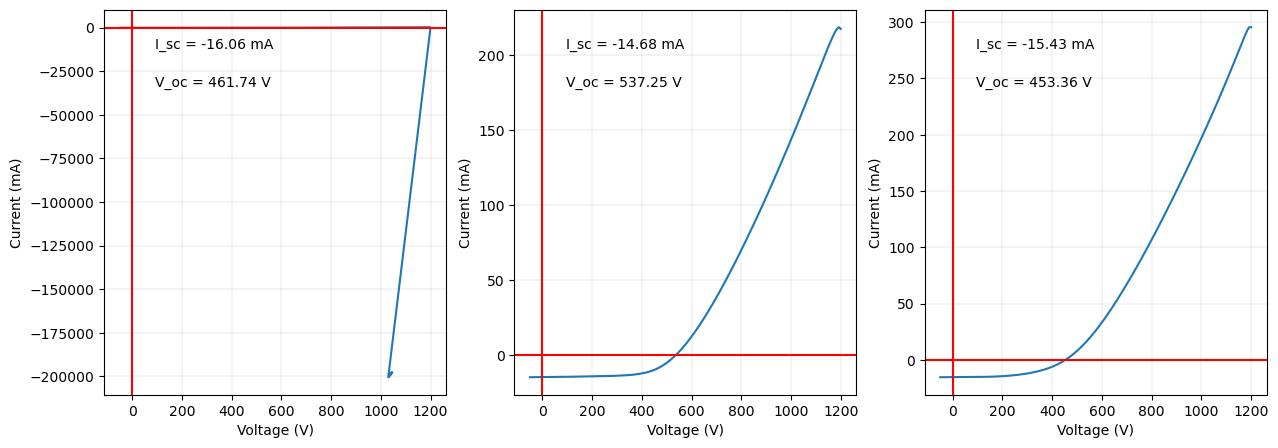

In [75]:
path = "JV\jv - 2"
file = "DK-DH-3-1.xls"

plot_jv(path, file)

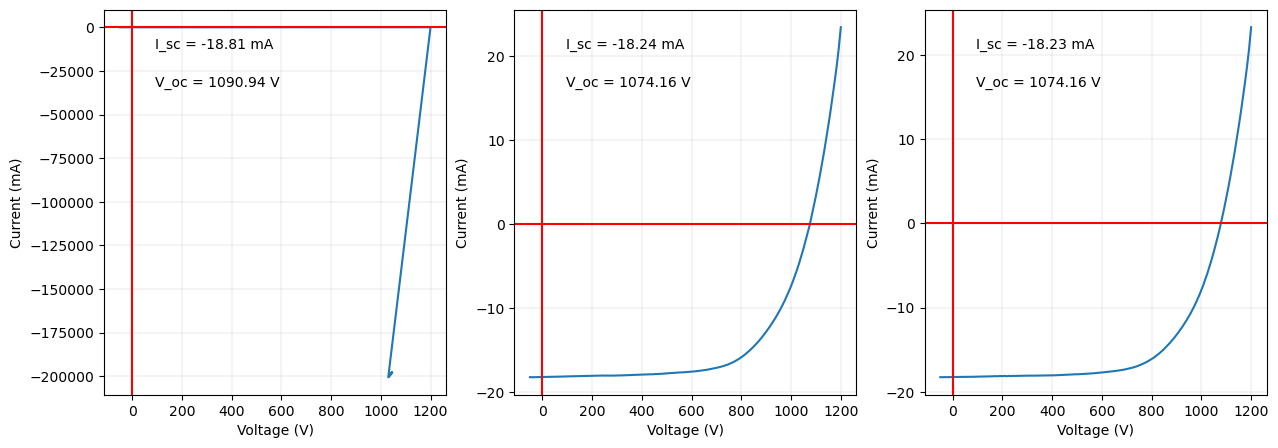

In [197]:
path = "JV\jv - 3_1"
file = "1-1.xls"

plot_jv(path, file)

In [222]:
path = "JV\jv - 2"

list_df = []
list_df.append(get_charac_df(path, "direct"))
list_df.append(get_charac_df(path, "reverse"))

write_to_xlsx(list_df, "jv_2")

In [224]:
path = "JV\jv - 2_2"

list_df = []
list_df.append(get_charac_df(path, "direct"))
list_df.append(get_charac_df(path, "reverse"))

write_to_xlsx(list_df, "jv_2_2")

In [225]:
path = "JV\jv - 1"

list_df = []
list_df.append(get_charac_df(path, "direct"))
list_df.append(get_charac_df(path, "reverse"))

write_to_xlsx(list_df, "jv_1")

In [226]:
path = "JV\jv - 3_1"

list_df = []
list_df.append(get_charac_df(path, "direct"))
list_df.append(get_charac_df(path, "reverse"))

write_to_xlsx(list_df, "jv_3_1")

In [229]:
path = "JV\jv - 3_2"

list_df = []
list_df.append(get_charac_df(path, "direct"))
list_df.append(get_charac_df(path, "reverse"))

write_to_xlsx(list_df, "jv_3_2")